In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [19]:
# Data loading
path = r'../data/processed/data_processed_v3.csv'
v3_df = pd.read_csv(path)
v3_df.info()
v3_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18336 entries, 0 to 18335
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      18336 non-null  int64  
 1   Week      18336 non-null  int64  
 2   Date      18336 non-null  object 
 3   Entity    18336 non-null  object 
 4   Epi_Year  18336 non-null  int64  
 5   M         18336 non-null  float64
 6   F         18336 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1002.9+ KB


,Year,Week,Date,Entity,Epi_Year,M,F
0,2014,2,2014-01-13,Aguascalientes,2014,0.0,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0,0.0


In [20]:
alzheimer_v3_df = v3_df.copy()
# Sort by entity and time
alzheimer_v3_df = alzheimer_v3_df.sort_values(['Entity', 'Year', 'Week']).reset_index(drop=True)

# Calculate weekly new cases for M and F
alzheimer_v3_df['M_new'] = alzheimer_v3_df.groupby('Entity')['M'].diff()
alzheimer_v3_df['F_new'] = alzheimer_v3_df.groupby('Entity')['F'].diff()

# Handle first week of each entity (no previous week to diff from)
first_rows = alzheimer_v3_df.groupby('Entity').head(1).index
alzheimer_v3_df.loc[first_rows, 'M_new'] = alzheimer_v3_df.loc[first_rows, 'M']
alzheimer_v3_df.loc[first_rows, 'F_new'] = alzheimer_v3_df.loc[first_rows, 'F']

# Handle Week 2 (epidemiological year reset)
alzheimer_v3_df.loc[alzheimer_v3_df['Week'] == 2, 'M_new'] = alzheimer_v3_df.loc[alzheimer_v3_df['Week'] == 2, 'M']
alzheimer_v3_df.loc[alzheimer_v3_df['Week'] == 2, 'F_new'] = alzheimer_v3_df.loc[alzheimer_v3_df['Week'] == 2, 'F']

# Replace original M and F columns with new incremental data
alzheimer_v3_df['M'] = alzheimer_v3_df['M_new']
alzheimer_v3_df['F'] = alzheimer_v3_df['F_new']

# Drop temporary columns
alzheimer_v3_df = alzheimer_v3_df.drop(columns=['M_new', 'F_new'])

# # Calculate total new cases per week
# alzheimer_v3_df['New_Cases'] = alzheimer_v3_df['M'] + alzheimer_v3_df['F']

alzheimer_v3_df.info()
alzheimer_v3_df[47:52]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18336 entries, 0 to 18335
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      18336 non-null  int64  
 1   Week      18336 non-null  int64  
 2   Date      18336 non-null  object 
 3   Entity    18336 non-null  object 
 4   Epi_Year  18336 non-null  int64  
 5   M         18336 non-null  float64
 6   F         18336 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1002.9+ KB


,Year,Week,Date,Entity,Epi_Year,M,F
47,2014,49,2014-12-08,Aguascalientes,2014,0.0,0.0
48,2014,50,2014-12-15,Aguascalientes,2014,0.0,1.0
49,2014,51,2014-12-22,Aguascalientes,2014,0.0,0.0
50,2014,52,2014-12-29,Aguascalientes,2014,0.0,0.0
51,2014,53,2015-01-05,Aguascalientes,2014,0.0,1.0


In [21]:
# OUTLIER DETECTION AND TREATMENT - Simplified with IQR=0 handling

def detect_and_cap_outliers_mf(df, entity_col='Entity', multiplier=3):
    '''
    Detect and cap extreme outliers in M and F separately
    Handles cases where IQR = 0 (no variation in data)
    '''
    df_result = df.copy()
    
    # Initialize flags and capped columns
    df_result['M_is_outlier'] = False
    df_result['F_is_outlier'] = False
    df_result['M_capped'] = df_result['M'].copy()
    df_result['F_capped'] = df_result['F'].copy()
    
    outlier_summary = []
    
    for entity in df[entity_col].unique():
        mask = df_result[entity_col] == entity
        
        # ===== Process M =====
        m_data = df_result.loc[mask, 'M']
        Q1_m = m_data.quantile(0.25)
        Q3_m = m_data.quantile(0.75)
        IQR_m = Q3_m - Q1_m
        
        # Only apply capping if there's variation in the data
        if IQR_m > 0:
            lower_m = Q1_m - multiplier * IQR_m
            upper_m = Q3_m + multiplier * IQR_m
            
            outlier_mask_m = (m_data < lower_m) | (m_data > upper_m)
            df_result.loc[mask & outlier_mask_m, 'M_is_outlier'] = True
            df_result.loc[mask, 'M_capped'] = m_data.clip(lower_m, upper_m)
            n_outliers_m = outlier_mask_m.sum()
        else:
            # No variation, keep original values
            n_outliers_m = 0
        
        # ===== Process F =====
        f_data = df_result.loc[mask, 'F']
        Q1_f = f_data.quantile(0.25)
        Q3_f = f_data.quantile(0.75)
        IQR_f = Q3_f - Q1_f
        
        # Only apply capping if there's variation in the data
        if IQR_f > 0:
            lower_f = Q1_f - multiplier * IQR_f
            upper_f = Q3_f + multiplier * IQR_f
            
            outlier_mask_f = (f_data < lower_f) | (f_data > upper_f)
            df_result.loc[mask & outlier_mask_f, 'F_is_outlier'] = True
            df_result.loc[mask, 'F_capped'] = f_data.clip(lower_f, upper_f)
            n_outliers_f = outlier_mask_f.sum()
        else:
            # No variation, keep original values
            n_outliers_f = 0
        
        # Track summary
        if n_outliers_m > 0 or n_outliers_f > 0:
            outlier_summary.append({
                'Entity': entity,
                'M_Outliers': n_outliers_m,
                'F_Outliers': n_outliers_f,
                'Total': n_outliers_m + n_outliers_f
            })
    
    # Create New_Cases from capped values
    df_result['New_Cases'] = df_result['M_capped'] + df_result['F_capped']
    
    # Print summary
    print("="*70)
    print("OUTLIER DETECTION SUMMARY")
    print("="*70)
    total_m = df_result['M_is_outlier'].sum()
    total_f = df_result['F_is_outlier'].sum()
    print(f"Total observations: {len(df_result)}")
    print(f"M outliers: {total_m} ({(total_m/len(df_result))*100:.2f}%)")
    print(f"F outliers: {total_f} ({(total_f/len(df_result))*100:.2f}%)")
    
    if outlier_summary:
        print(f"\nEntities with outliers: {len(outlier_summary)}")
        summary_df = pd.DataFrame(outlier_summary).sort_values('Total', ascending=False)
        print("\nTop 10 entities:")
        print(summary_df.head(10).to_string(index=False))
    
    return df_result

# Step 1: Detect and cap outliers
alzheimer_clean = detect_and_cap_outliers_mf(
    alzheimer_v3_df,
    entity_col='Entity',
    multiplier=3
)

# Step 2: Check which entities have outliers
entities_with_outliers = alzheimer_clean[
    alzheimer_clean['M_is_outlier'] | alzheimer_clean['F_is_outlier']
]['Entity'].unique()


OUTLIER DETECTION SUMMARY
Total observations: 18336
M outliers: 16 (0.09%)
F outliers: 54 (0.29%)

Entities with outliers: 21

Top 10 entities:
    Entity  M_Outliers  F_Outliers  Total
  Coahuila           1           7      8
    Colima           1           6      7
    Puebla           0           7      7
    Oaxaca           1           5      6
Tamaulipas           0           5      5
   Nayarit           2           3      5
 Michoacán           1           3      4
   Yucatán           0           4      4
   Morelos           0           3      3
    Sonora           2           1      3


In [22]:

print(f"\n{len(entities_with_outliers)} entities have outliers")


21 entities have outliers



Visualizing: Chiapas


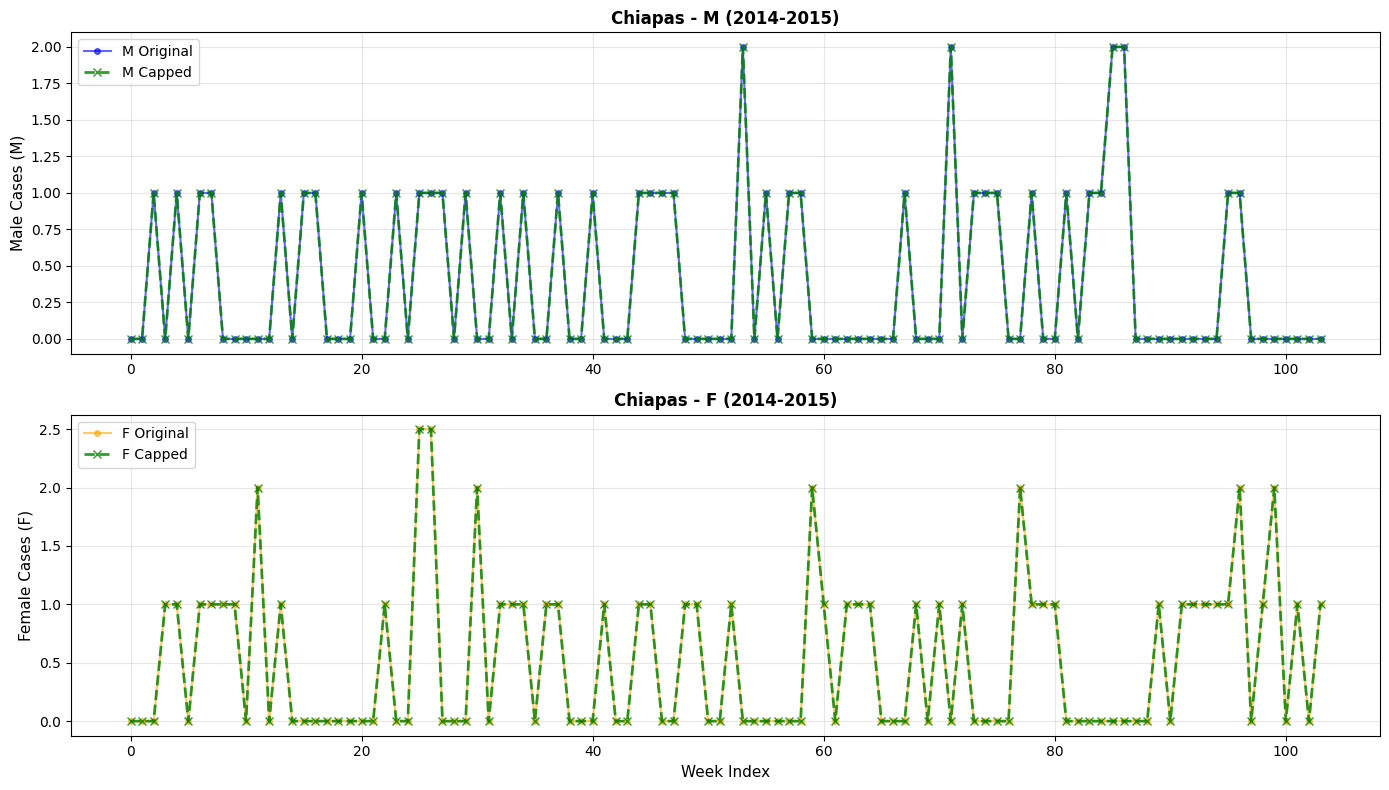

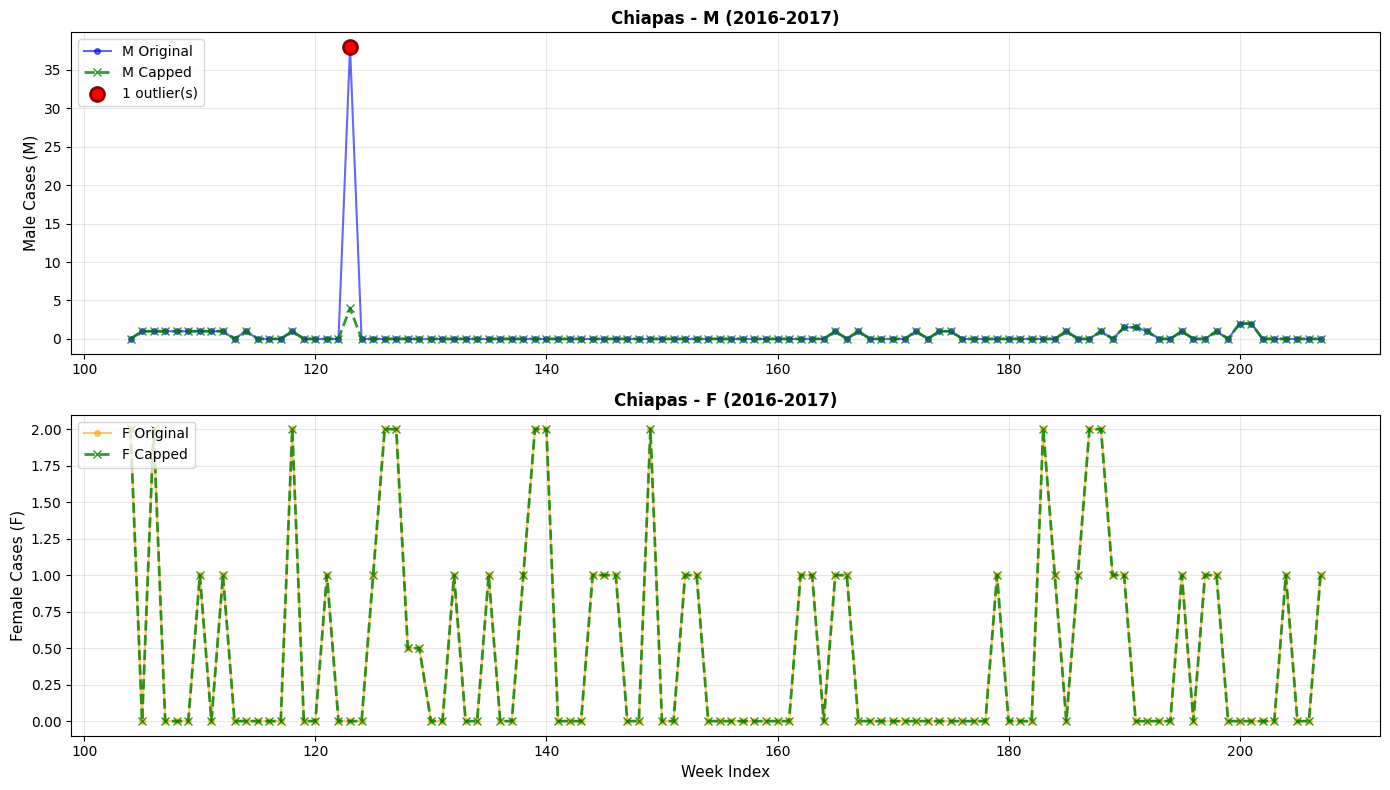

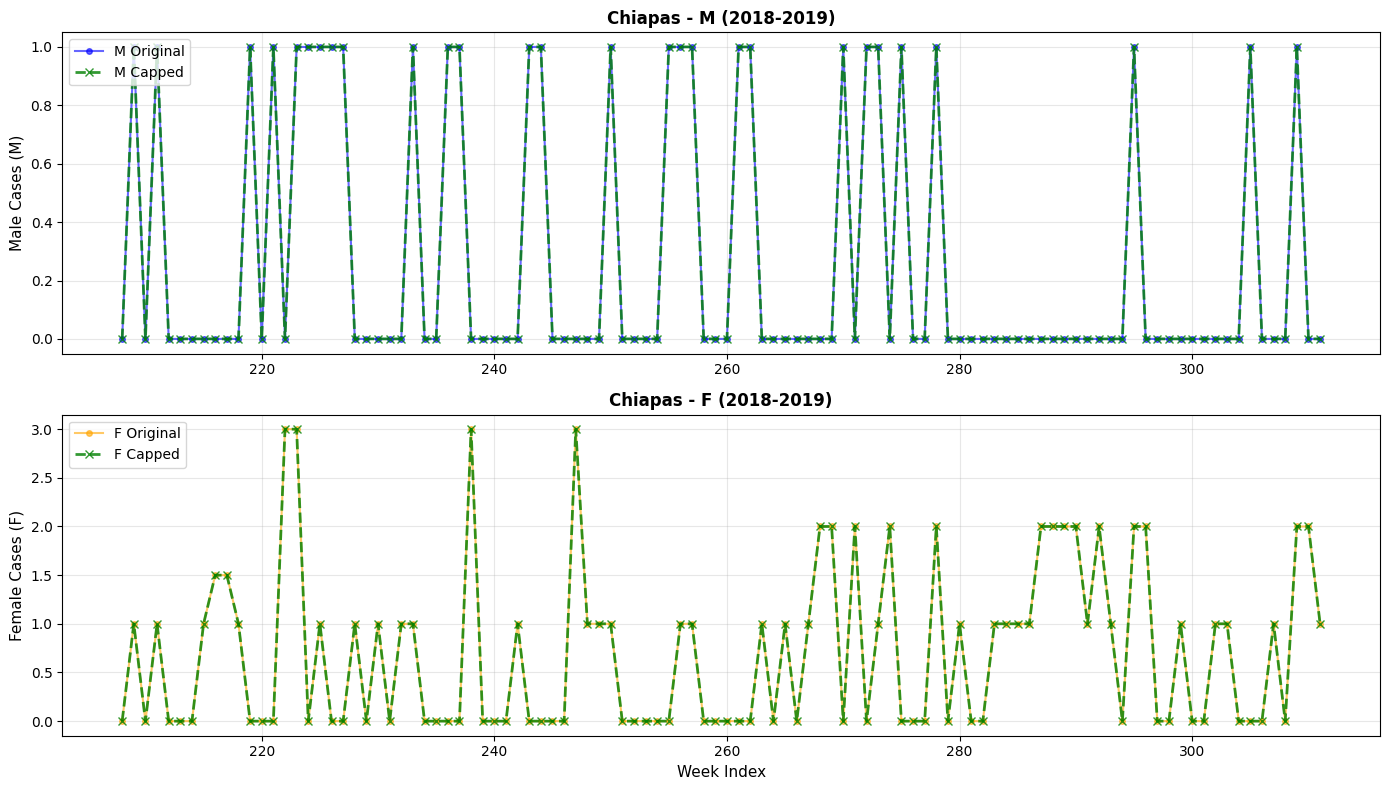

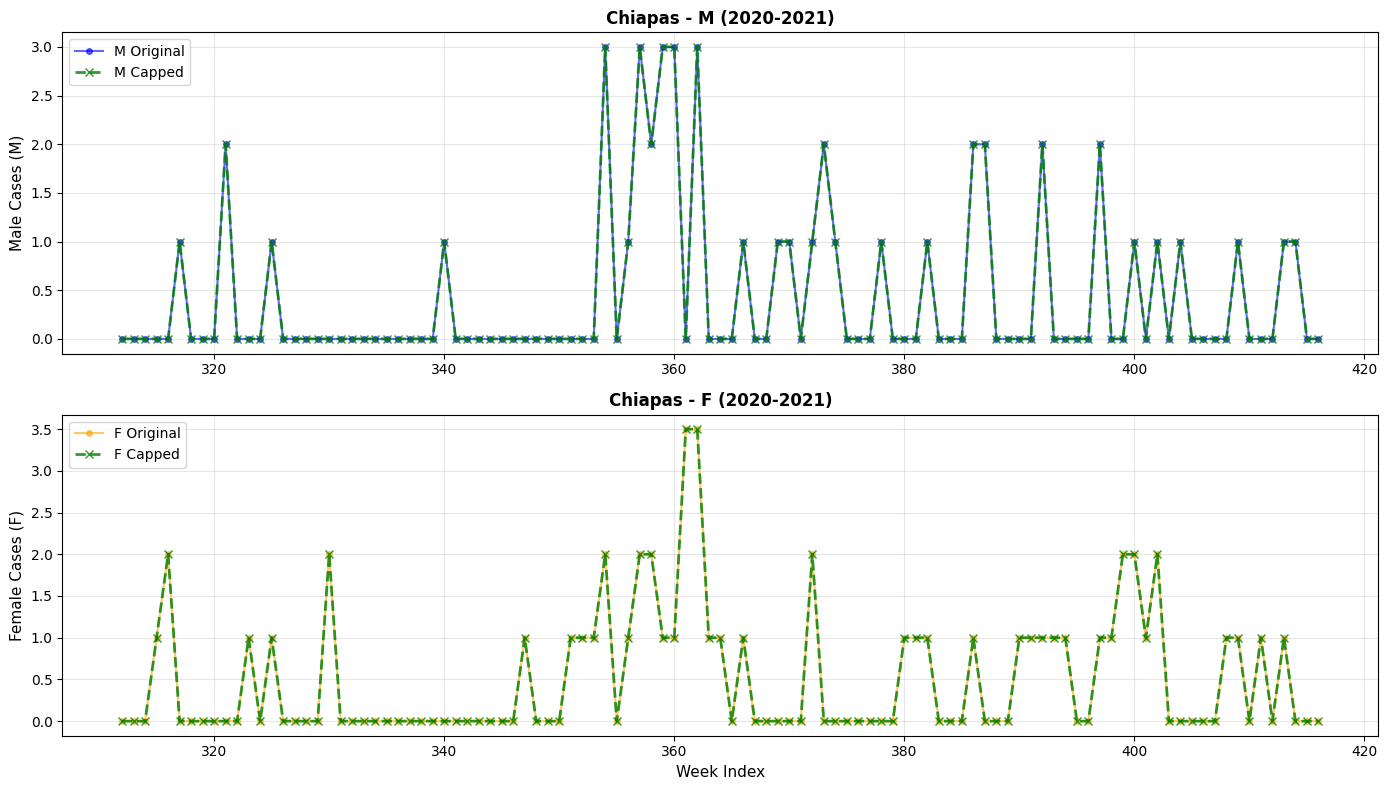

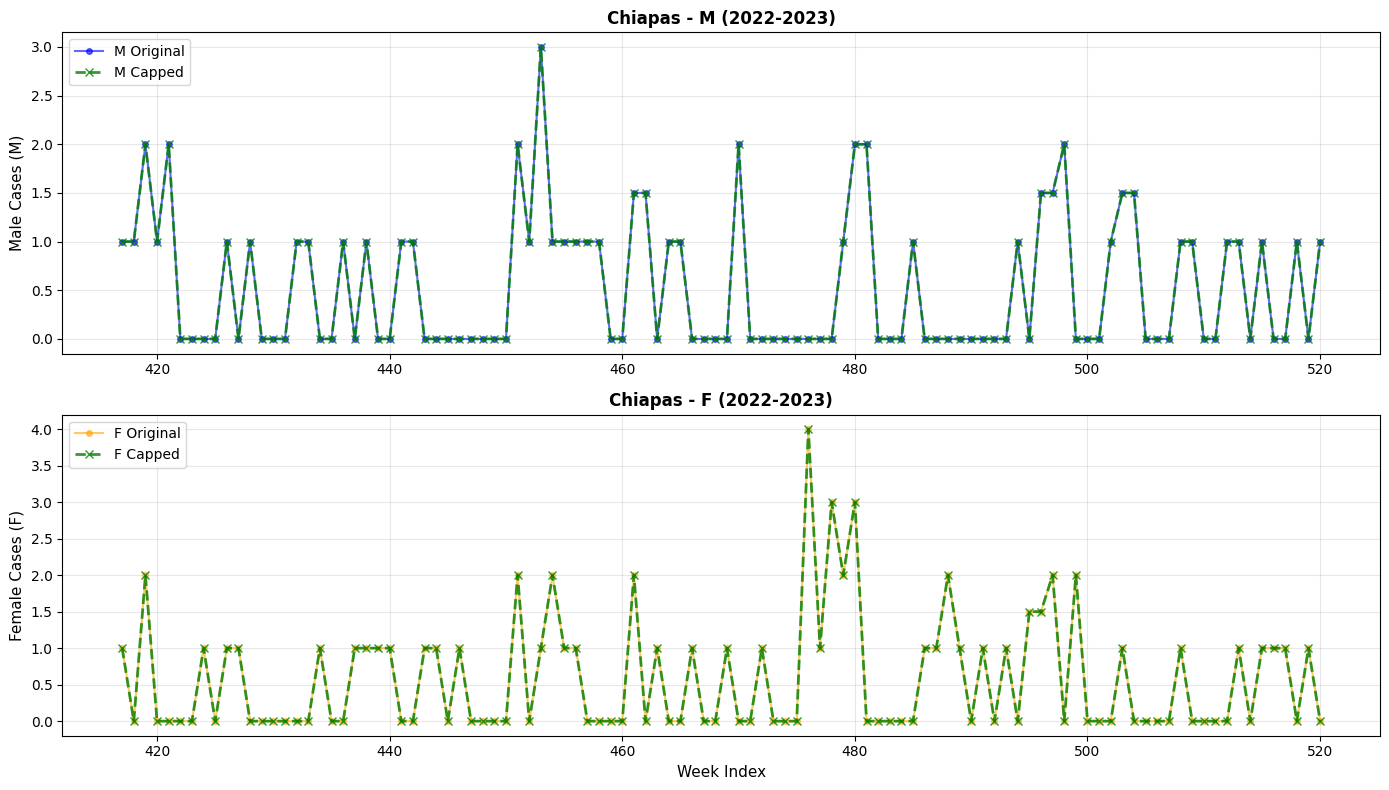

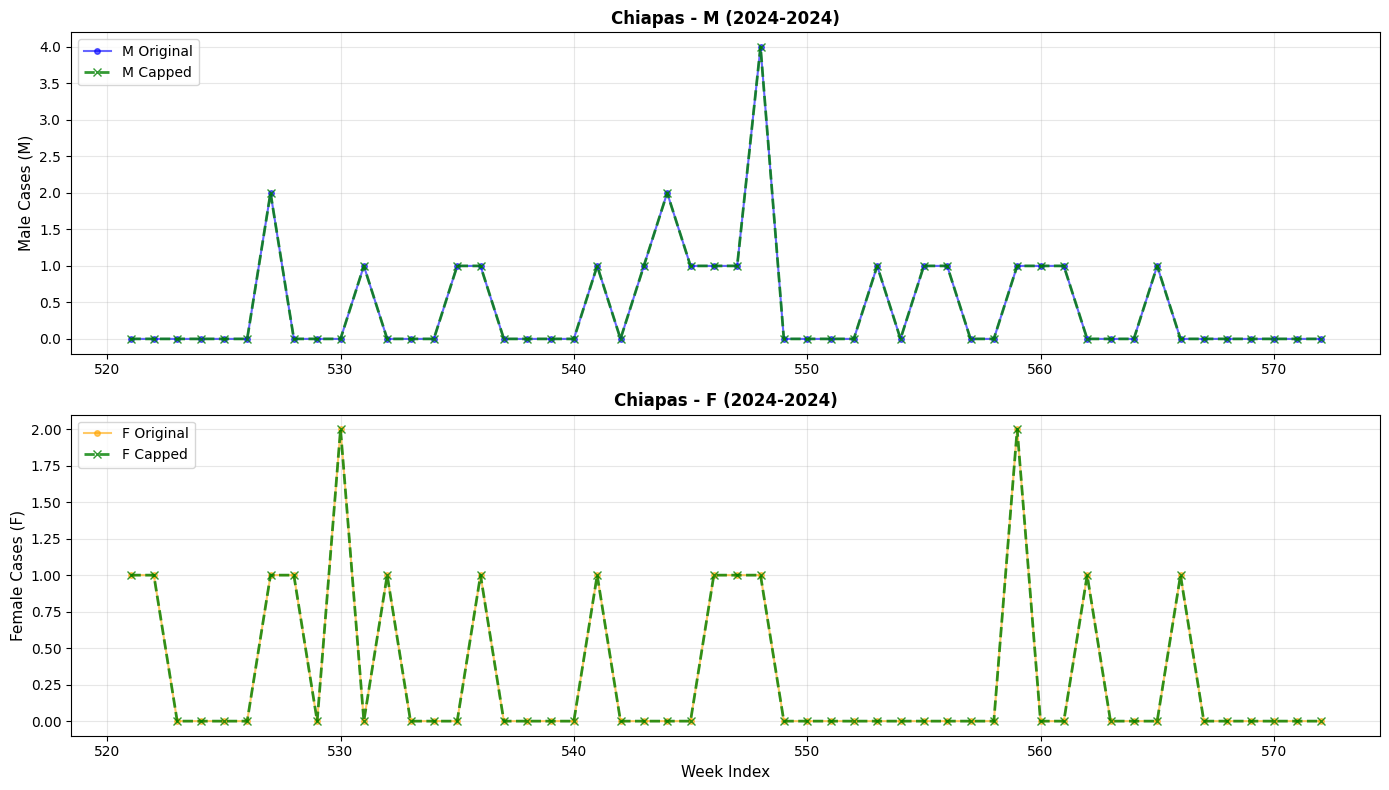

In [ ]:
def visualize_entity_by_periods(df, entity_name, years_per_plot=2):
    '''
    Visualize one entity, split into 2-year periods for clarity
    '''
    entity_data = df[df['Entity'] == entity_name].copy()
    entity_data = entity_data.sort_values(['Year', 'Week']).reset_index(drop=True)
    
    # Get year range
    years = sorted(entity_data['Year'].unique())
    n_years = len(years)
    
    # Split into 2-year periods
    periods = []
    for i in range(0, n_years, years_per_plot):
        period_years = years[i:i+years_per_plot]
        periods.append(period_years)
    
    # Create one figure per period
    for period in periods:
        period_data = entity_data[entity_data['Year'].isin(period)]
        
        # Create figure with 2 rows (M and F)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
        
        # ===== M Plot =====
        ax1.plot(period_data.index, period_data['M'], 'o-', 
                 alpha=0.6, color='blue', label='M Original', markersize=4)
        ax1.plot(period_data.index, period_data['M_capped'], 'x--',
                 alpha=0.8, color='green', label='M Capped', markersize=6, linewidth=2)
        
        # Highlight outliers
        outliers_m = period_data[period_data['M_is_outlier']]
        if len(outliers_m) > 0:
            ax1.scatter(outliers_m.index, outliers_m['M'],
                       color='red', s=100, zorder=5, edgecolors='darkred', 
                       linewidth=2, label=f'{len(outliers_m)} outlier(s)')
        
        ax1.set_ylabel('Male Cases (M)', fontsize=11)
        ax1.set_title(f'{entity_name} - M ({period[0]}-{period[-1]})', 
                     fontsize=12, weight='bold')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # ===== F Plot =====
        ax2.plot(period_data.index, period_data['F'], 'o-',
                 alpha=0.6, color='orange', label='F Original', markersize=4)
        ax2.plot(period_data.index, period_data['F_capped'], 'x--',
                 alpha=0.8, color='green', label='F Capped', markersize=6, linewidth=2)
        
        # Highlight outliers
        outliers_f = period_data[period_data['F_is_outlier']]
        if len(outliers_f) > 0:
            ax2.scatter(outliers_f.index, outliers_f['F'],
                       color='red', s=100, zorder=5, edgecolors='darkred',
                       linewidth=2, label=f'{len(outliers_f)} outlier(s)')
        
        ax2.set_xlabel('Week Index', fontsize=11)
        ax2.set_ylabel('Female Cases (F)', fontsize=11)
        ax2.set_title(f'{entity_name} - F ({period[0]}-{period[-1]})',
                     fontsize=12, weight='bold')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Step 3: Visualize one entity at a time (2-year periods)
if len(entities_with_outliers) > 0:
    # Show first entity with outliers
    entity_to_plot = entities_with_outliers[1]
    print(f"\nVisualizing: {entity_to_plot}")
    visualize_entity_by_periods(alzheimer_clean, entity_to_plot, years_per_plot=2)

In [24]:
# Step 4: Create final dataset
alzheimer_v3_df_clean = alzheimer_clean.copy()
alzheimer_v3_df_clean['M'] = alzheimer_v3_df_clean['M_capped']
alzheimer_v3_df_clean['F'] = alzheimer_v3_df_clean['F_capped']
alzheimer_v3_df_clean = alzheimer_v3_df_clean[['Year', 'Week', 'Date', 'Entity', 
                                                 'Epi_Year', 'M', 'F', 'New_Cases']]

alzheimer_v3_df_clean.info()
alzheimer_v3_df_clean[47:52]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18336 entries, 0 to 18335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       18336 non-null  int64  
 1   Week       18336 non-null  int64  
 2   Date       18336 non-null  object 
 3   Entity     18336 non-null  object 
 4   Epi_Year   18336 non-null  int64  
 5   M          18336 non-null  float64
 6   F          18336 non-null  float64
 7   New_Cases  18336 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.1+ MB


,Year,Week,Date,Entity,Epi_Year,M,F,New_Cases
47,2014,49,2014-12-08,Aguascalientes,2014,0.0,0.0,0.0
48,2014,50,2014-12-15,Aguascalientes,2014,0.0,1.0,1.0
49,2014,51,2014-12-22,Aguascalientes,2014,0.0,0.0,0.0
50,2014,52,2014-12-29,Aguascalientes,2014,0.0,0.0,0.0
51,2014,53,2015-01-05,Aguascalientes,2014,0.0,1.0,1.0


In [ ]:
# output_folder = '../data/processed/'
# filename = 'data_processed_v3_outliers_trated.csv'
# path = os.path.join(output_folder, filename)

# alzheimer_v3_df_clean.to_csv(
#     path,
#     index=False,
#     encoding='utf-8'
# )